Генерация графиков с исправленным кодом:


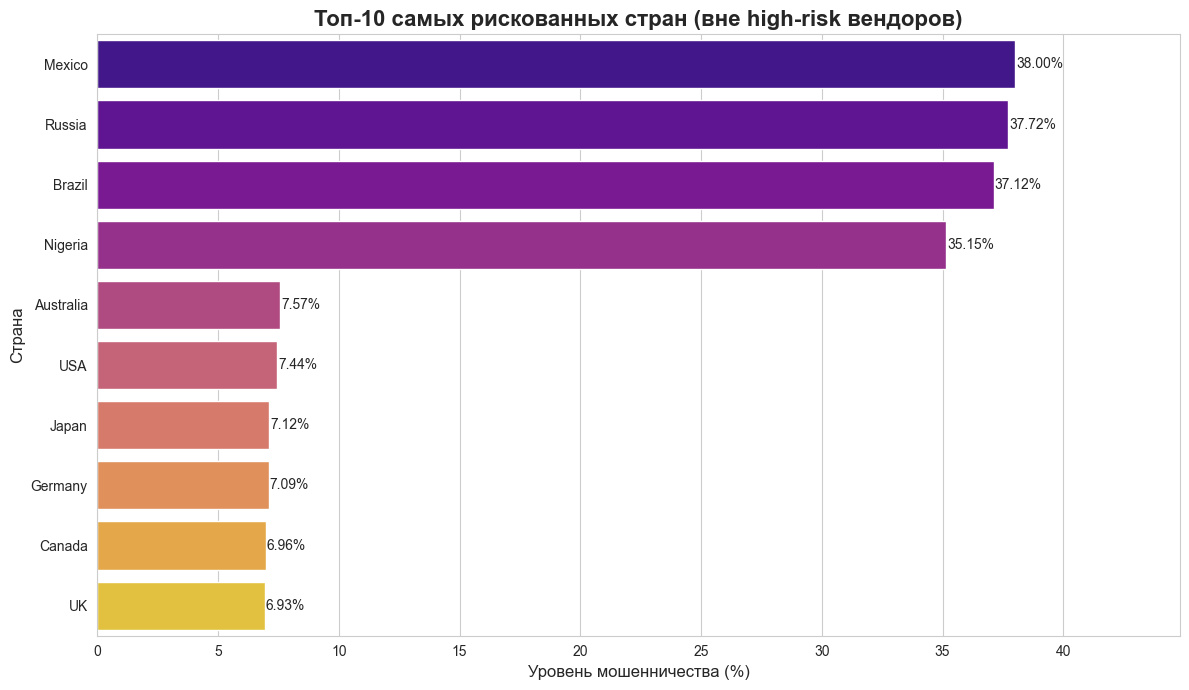

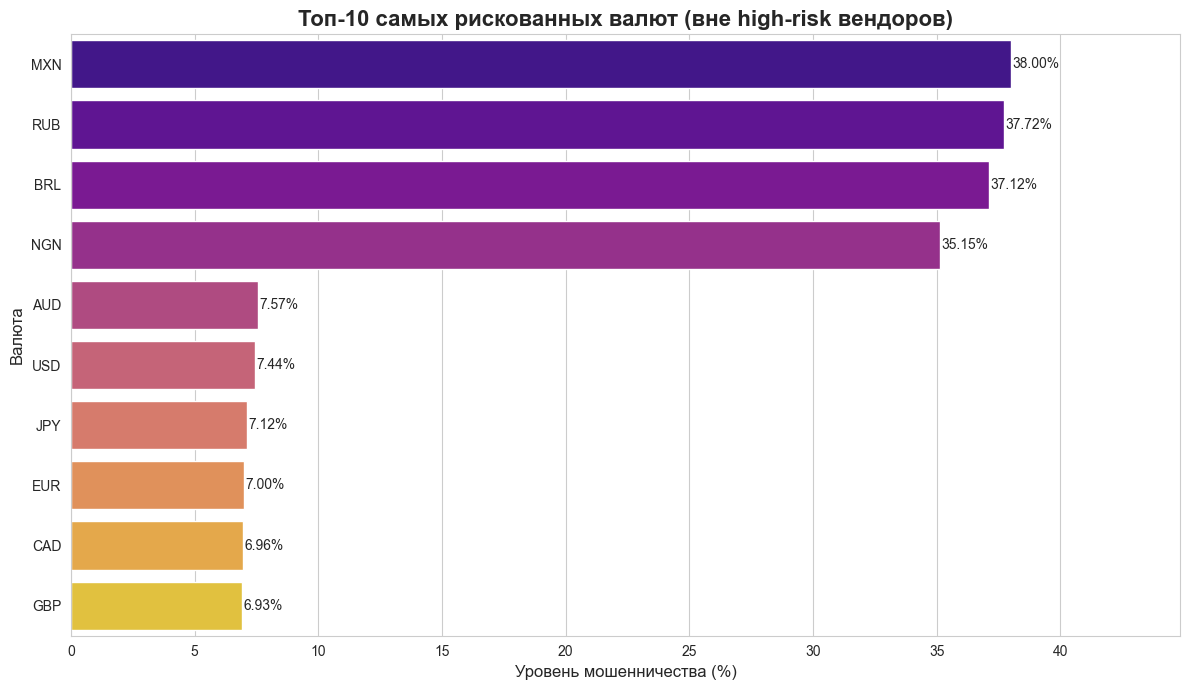

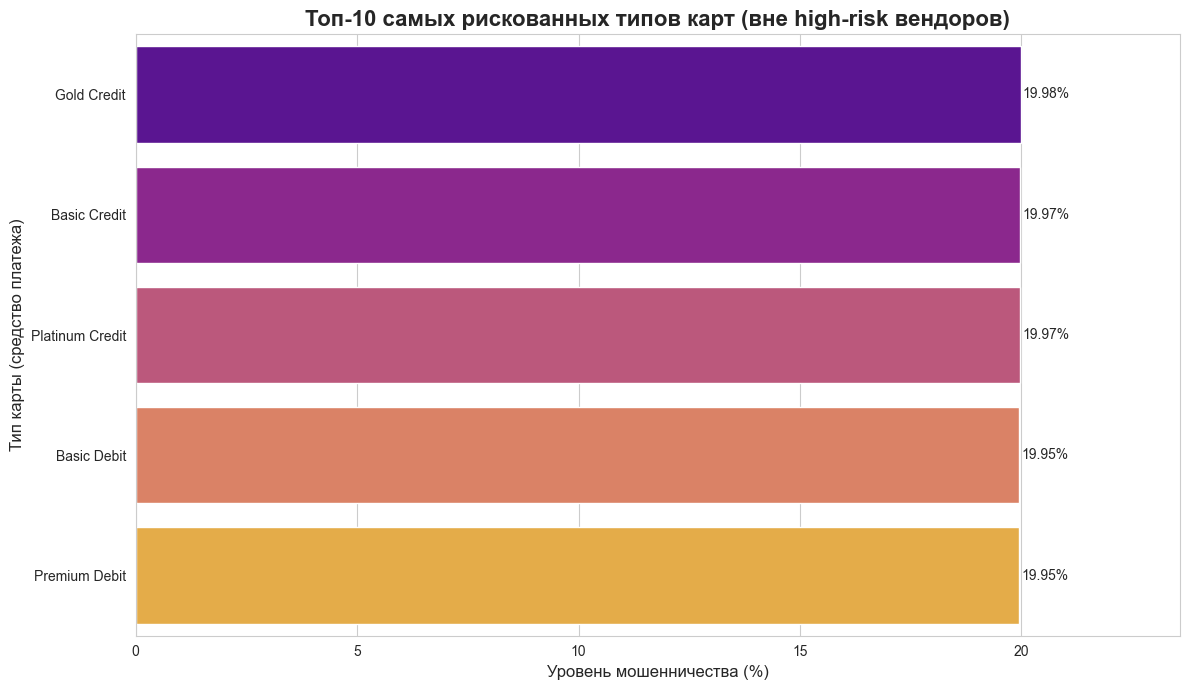

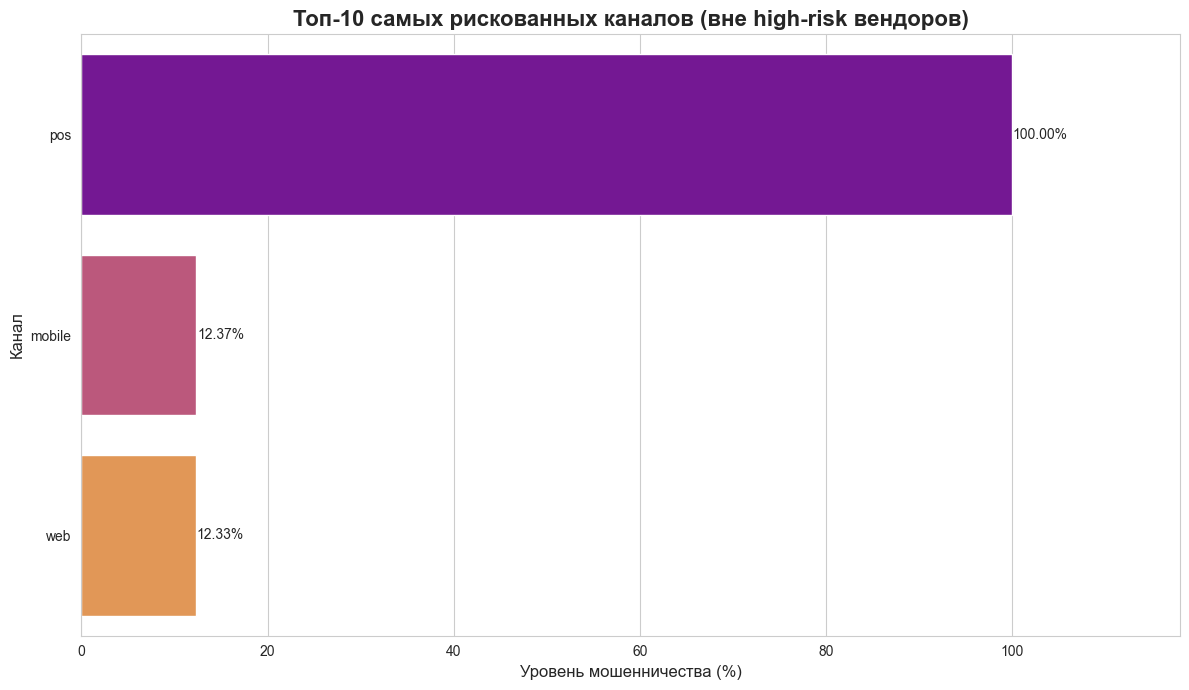

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки для графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# Загрузка данных
try:
    df = pd.read_parquet('transaction_fraud_data.parquet')
except FileNotFoundError:
    print("Файл 'transaction_fraud_data.parquet' не найден.")
    df = pd.DataFrame()

# Фильтрация данных
safe_vendors_df = df[df['is_high_risk_vendor'] == False].copy()

def analyze_and_plot_risk(dataframe, category_column, top_n=10):
    """
    Анализирует риск по категории и строит график (с обновленным синтаксисом).
    """
    analysis = dataframe.groupby(category_column).agg(
        total_transactions=('transaction_id', 'count'),
        fraud_transactions=('is_fraud', 'sum')
    ).reset_index()
    analysis['fraud_rate'] = (analysis['fraud_transactions'] / analysis['total_transactions']) * 100
    
    top_risky = analysis.sort_values('fraud_rate', ascending=False).head(top_n)

    plt.figure(figsize=(12, 7))
    
    # --- ИСПРАВЛЕННАЯ СТРОКА ---
    # Мы явно указываем, что цветом (hue) нужно выделить категории с оси Y,
    # и отключаем ненужную в данном случае легенду.
    ax = sns.barplot(
        x='fraud_rate', 
        y=category_column, 
        data=top_risky, 
        orient='h', 
        palette='plasma', 
        hue=category_column,  # Явно указываем, что раскрашивать
        legend=False          # Отключаем дублирующую легенду
    )
    # --- КОНЕЦ ИСПРАВЛЕНИЯ ---

    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 0.05, p.get_y() + p.get_height() / 2, f'{width:.2f}%', va='center')

    title_map = {
        'country': 'стран', 'currency': 'валют',
        'card_type': 'типов карт', 'channel': 'каналов'
    }
    category_map = {
        'country': 'Страна', 'currency': 'Валюта',
        'card_type': 'Тип карты (средство платежа)', 'channel': 'Канал'
    }
    
    plt.title(f'Топ-{top_n} самых рискованных {title_map.get(category_column)} (вне high-risk вендоров)', fontsize=16, weight='bold')
    plt.xlabel('Уровень мошенничества (%)', fontsize=12)
    plt.ylabel(category_map.get(category_column), fontsize=12)
    plt.xlim(0, top_risky['fraud_rate'].max() * 1.18)
    plt.tight_layout()
    plt.show()

# --- Повторный запуск для генерации графиков без предупреждений ---
if not df.empty:
    print("Генерация графиков с исправленным кодом:")
    analyze_and_plot_risk(safe_vendors_df, 'country')
    analyze_and_plot_risk(safe_vendors_df, 'currency')
    analyze_and_plot_risk(safe_vendors_df, 'card_type')
    analyze_and_plot_risk(safe_vendors_df, 'channel')